In [1]:
import os
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization
from plotly.offline import init_notebook_mode, plot,iplot

# from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
# from sklearn.neighbors import kneighbors_graph
from sklearn import (manifold, decomposition)

init_notebook_mode(connected=True)

datadir = os.path.join('.','data2020', 'players_20.csv')

# Curación

## Curacion de los datos (variables de soporte)

Explicacion de las [features](https://www.fifauteam.com/fifa-20-attributes-guide/)

In [2]:
#######################################################################
cols2keep_obj = list()
cols2keep_num = list()

# Features generales
cols2keep_obj.append('short_name')
cols2keep_obj.append('club')
cols2keep_obj.append('player_positions')
cols2keep_obj.append('preferred_foot')
cols2keep_obj.append('team_position')

cols2keep_num.append('height_cm')
cols2keep_num.append('weight_kg')
cols2keep_num.append('overall')
cols2keep_num.append('work_rate')
cols2keep_num.append('shooting')
cols2keep_num.append('passing')
cols2keep_num.append('dribbling')
cols2keep_num.append('defending')
cols2keep_num.append('physic')

# Features relativas a un arquero
cols2keep_num.append('goalkeeping_diving')
cols2keep_num.append('goalkeeping_handling')
cols2keep_num.append('goalkeeping_kicking')
cols2keep_num.append('goalkeeping_reflexes')
cols2keep_num.append('goalkeeping_positioning')

# Features relativas a la capacidad de ataque
cols2keep_num.append('attacking_crossing')
cols2keep_num.append('attacking_finishing')
cols2keep_num.append('attacking_heading_accuracy')
cols2keep_num.append('attacking_short_passing')
cols2keep_num.append('attacking_volleys')

# Features relativas a las habilidades
cols2keep_num.append('skill_moves')
cols2keep_num.append('skill_dribbling')
cols2keep_num.append('skill_curve')
cols2keep_num.append('skill_fk_accuracy')
cols2keep_num.append('skill_long_passing')
cols2keep_num.append('skill_ball_control')

# Features relativas a la movilidad
cols2keep_num.append('movement_acceleration')
cols2keep_num.append('movement_sprint_speed')
cols2keep_num.append('movement_agility')
cols2keep_num.append('movement_reactions')
cols2keep_num.append('movement_balance')

# Features relativas a la potencia
cols2keep_num.append('power_shot_power')
cols2keep_num.append('power_jumping')
cols2keep_num.append('power_stamina')
cols2keep_num.append('power_strength')
cols2keep_num.append('power_long_shots')

# Features relativas a las soft skills
cols2keep_num.append('mentality_aggression')
cols2keep_num.append('mentality_interceptions')
cols2keep_num.append('mentality_positioning')
cols2keep_num.append('mentality_vision')
cols2keep_num.append('mentality_penalties')
cols2keep_num.append('mentality_composure')

# Features relativas a la defensa
cols2keep_num.append('defending_marking')
cols2keep_num.append('defending_standing_tackle')
cols2keep_num.append('defending_sliding_tackle')

#######################################################################
# Columnas con campos en NaN
cols2fix = list()
cols2fix.append('shooting')
cols2fix.append('passing')
cols2fix.append('dribbling')
cols2fix.append('defending')
cols2fix.append('physic')

# Regla de transformacion de work_rate
regla = dict()
regla['High/High'] = 4
regla['High/Medium'] = 3
regla['High/Low'] = 2
regla['Medium/High'] = 1 
regla['Medium/Medium'] = 0
regla['Medium/Low'] = -1
regla['Low/High'] = -2
regla['Low/Medium'] = -3
regla['Low/Low'] = -4

## Curación de los datos (ejecución)

In [3]:
#1. Cargamos el conjunto de datos fifa 2020
dfn = pd.read_csv(datadir)
dfn = dfn.sample(n=4000)

#2. Tomamos la metadata que nos interesa `cols2keep_obj` 
dfo = dfn[cols2keep_obj]

#3. Tomamos solo las columnas que nos interesan `cols2keep_num`
dfn = dfn[cols2keep_num]

#4. Se completan con cero las entradas de las columnas `cols2fix` para remover los NaN
dfn[cols2fix] = dfn[cols2fix].fillna(0)

#5. Se completan con "Undef" las entradas de la columna `team_position` para remover los NaN
dfn['work_rate'] = dfn.work_rate.apply(lambda x: regla[x])

#6. S convierte `work_rate` a categorica numérica en el rango [-4, 4]
dfo['team_position'] = dfo.team_position.fillna('Undef')

display(dfo.info())
display('####################')
display(dfn.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 8154 to 3130
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   short_name        4000 non-null   object
 1   club              4000 non-null   object
 2   player_positions  4000 non-null   object
 3   preferred_foot    4000 non-null   object
 4   team_position     4000 non-null   object
dtypes: object(5)
memory usage: 187.5+ KB


None

'####################'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 8154 to 3130
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   height_cm                   4000 non-null   int64  
 1   weight_kg                   4000 non-null   int64  
 2   overall                     4000 non-null   int64  
 3   work_rate                   4000 non-null   int64  
 4   shooting                    4000 non-null   float64
 5   passing                     4000 non-null   float64
 6   dribbling                   4000 non-null   float64
 7   defending                   4000 non-null   float64
 8   physic                      4000 non-null   float64
 9   goalkeeping_diving          4000 non-null   int64  
 10  goalkeeping_handling        4000 non-null   int64  
 11  goalkeeping_kicking         4000 non-null   int64  
 12  goalkeeping_reflexes        4000 non-null   int64  
 13  goalkeeping_positioning     40

None

In [4]:
dfo.head(5)

,short_name,club,player_positions,preferred_foot,team_position
8154,Pablo Trigueros,SD Ponferradina,CB,Right,RCB
7973,S. Ferreira,Monarcas Morelia,ST,Right,SUB
4662,H. Kiyotake,Cerezo Osaka,"LM, CF, RM",Right,LM
5083,R. Schoofs,KV Mechelen,"CM, CDM",Left,LDM
5954,I. Ljubić,SK Sturm Graz,"CM, CDM",Right,SUB


In [5]:
dfn.head(5)

,height_cm,weight_kg,overall,work_rate,shooting,passing,dribbling,defending,physic,goalkeeping_diving,...,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle
8154,188,75,67,0,37.0,47.0,45.0,66.0,71.0,10,...,30,70,63,37,45,45,64,67,68,67
7973,180,78,67,0,65.0,55.0,67.0,29.0,57.0,5,...,59,41,30,64,60,70,62,19,27,25
4662,172,66,71,0,65.0,71.0,71.0,40.0,58.0,15,...,60,28,31,71,72,75,73,48,35,33
5083,178,69,70,3,63.0,71.0,70.0,60.0,61.0,8,...,70,57,66,70,69,53,74,62,57,58
5954,184,75,69,0,62.0,64.0,68.0,66.0,69.0,13,...,64,62,65,65,67,60,65,69,65,64


In [6]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, n_jobs=2)
X_tsne = tsne.fit_transform(dfn)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.014s...
[t-SNE] Computed neighbors for 4000 samples in 0.591s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 14.488640
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.004066
[t-SNE] KL divergence after 1000 iterations: 1.556578
t-SNE done! Time elapsed: 8.849858522415161 seconds


In [7]:
X_tsne[3990:4000]

array([[-29.3735   ,  34.67722  ],
       [ 18.197927 ,   7.6868734],
       [-28.937828 ,  28.424694 ],
       [ 56.446877 ,  38.504784 ],
       [-64.76495  ,  17.527573 ],
       [  2.349583 ,  33.684906 ],
       [  7.5557585, -32.569916 ],
       [-72.12045  ,  -5.7973256],
       [ 64.29033  ,  39.119625 ],
       [ 60.13454  ,  37.388775 ]], dtype=float32)

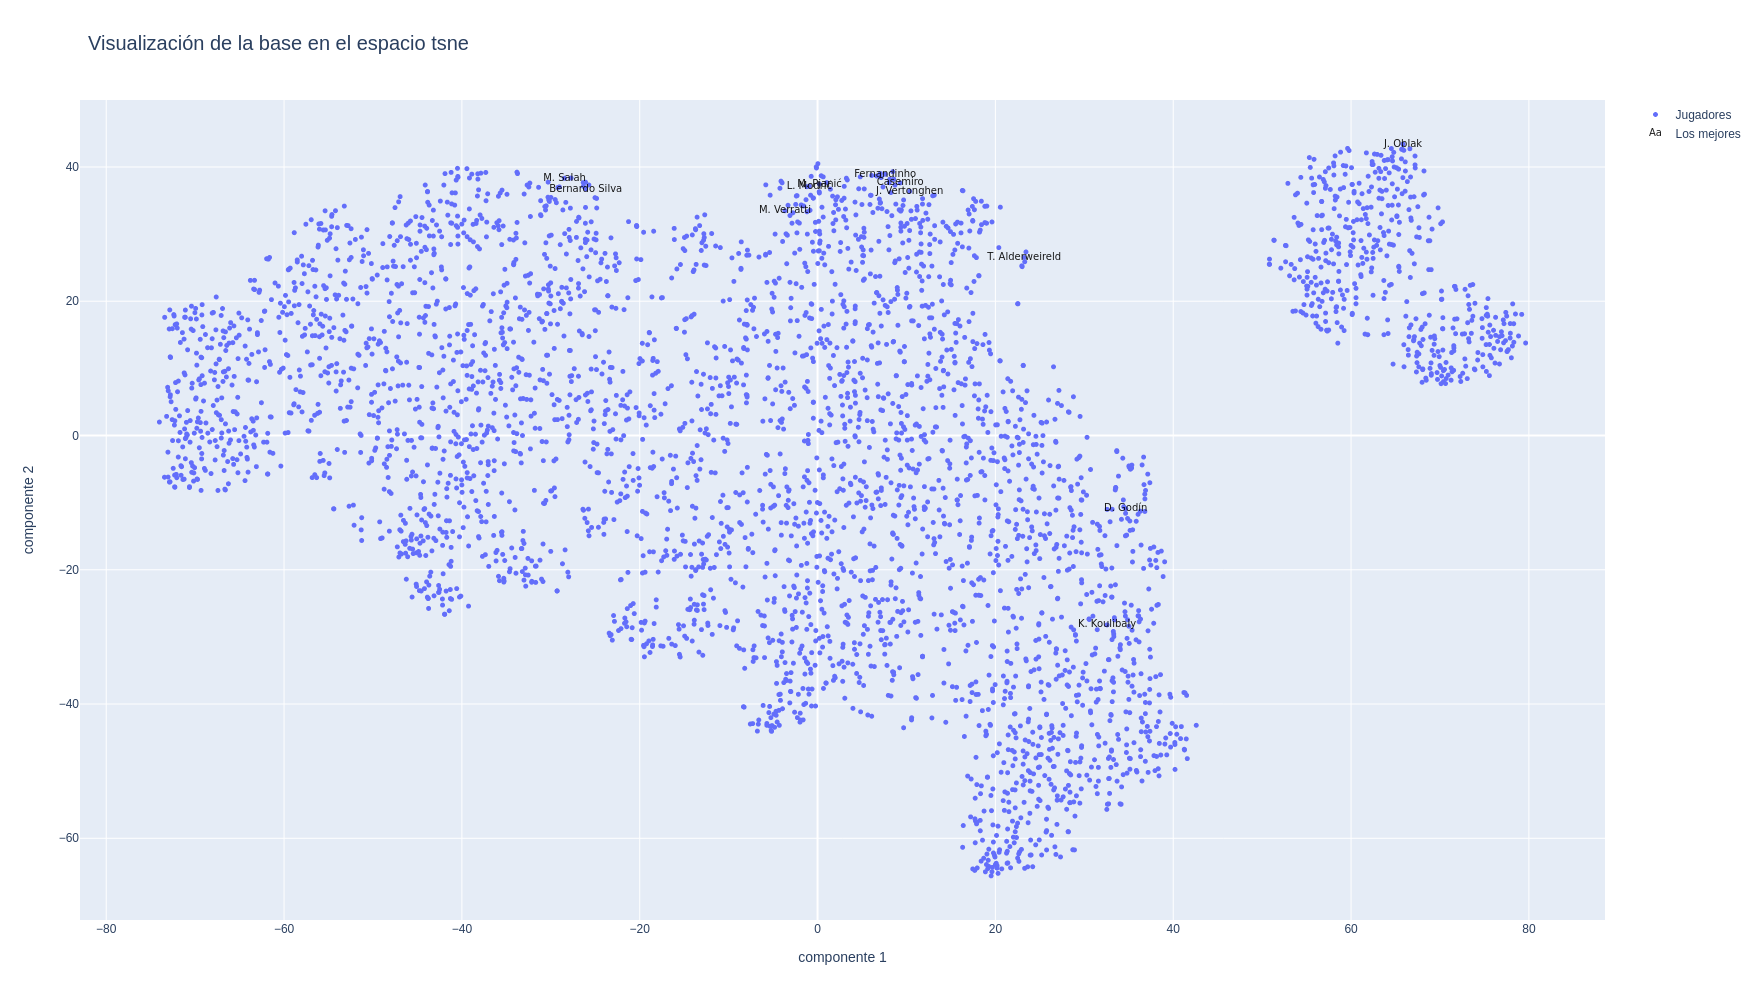

In [8]:
data=[]
bool_crack=dfn.overall > 85

#graficamos los datos en el espacio transformado: las dos componentes tsne

graf1 = go.Scatter(x=X_tsne[:,0], y=X_tsne[:,1],
                   name='Jugadores',
                   mode='markers',
                   text=dfo[['club', 'team_position']].apply(lambda x:f'{x.club} - {x.team_position}', axis=1),
                   marker=dict(size=5))

crack =go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],
                  name='Los mejores',
                  text=dfo.loc[bool_crack,'short_name'],
                  textfont=dict(family='sans serif',size=10,color='black'),
                  opacity=0.9,
                  mode='text')

data=[graf1, crack]

layout = go.Layout(title="Visualización de la base en el espacio tsne",titlefont=dict(size=20),
                   xaxis=dict(title='componente 1'),
                   yaxis=dict(title='componente 2'),
                   autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)
# plot(fig)

In [9]:
dfo[['short_name','player_positions', 'team_position']]

,short_name,player_positions,team_position
8154,Pablo Trigueros,CB,RCB
7973,S. Ferreira,ST,SUB
4662,H. Kiyotake,"LM, CF, RM",LM
5083,R. Schoofs,"CM, CDM",LDM
5954,I. Ljubić,"CM, CDM",SUB
...,...,...,...
2481,M. Risse,"RM, RB",SUB
14941,L. Donnelly,"RB, CDM, CB",CDM
17595,J. Vazquez,ST,RES
7192,Gu Chao,GK,GK


In [10]:
def pos_tranf(pp, tp):
    forwards = set(['RF', 'ST', 'LW', 'LF', 'RS', 'LS', 'RM', 'LM','RW'])
    midfielders = set(['RCM','LCM','LDM','CAM','CDM','LAM','RDM','CM','RAM','CF'])
    defenders = set(['RCB','CB','LCB','LB','RB','RWB','LWB'])
    goalkeepers = set(['GK'])
    
    tocheck = set(pp) | set(tp)
    
    if  tocheck & forwards:
        return 'Forward'
    
    elif tocheck & midfielders:
        return 'Midfielder'
    
    elif tocheck & defenders:
        return 'Defender'
    
    elif tocheck & goalkeepers:
        return 'GoalKeeper'
    
    else:
        return 'NaN'

In [11]:
dfo['position'] = dfo.apply(lambda x: pos_tranf(x.player_positions.split(', '), x.team_position.split(', ')), axis=1)
display(dfo.head(10))
display(dfo.position.value_counts())

,short_name,club,player_positions,preferred_foot,team_position,position
8154,Pablo Trigueros,SD Ponferradina,CB,Right,RCB,Defender
7973,S. Ferreira,Monarcas Morelia,ST,Right,SUB,Forward
4662,H. Kiyotake,Cerezo Osaka,"LM, CF, RM",Right,LM,Forward
5083,R. Schoofs,KV Mechelen,"CM, CDM",Left,LDM,Midfielder
5954,I. Ljubić,SK Sturm Graz,"CM, CDM",Right,SUB,Midfielder
4799,Rodri Tarín,CD Leganés,"CB, RB",Right,SUB,Defender
6368,D. Čop,Standard de Liège,ST,Right,RES,Forward
16658,R. Pasquel,Deportivo Toluca,GK,Right,SUB,GoalKeeper
8345,S. Ishizaki,IF Elfsborg,"CM, CAM",Right,SUB,Midfielder
4371,O. Vranješ,AEK Athens,"CB, RB",Right,RCB,Defender


Forward       1533
Defender      1069
Midfielder     935
GoalKeeper     463
Name: position, dtype: int64

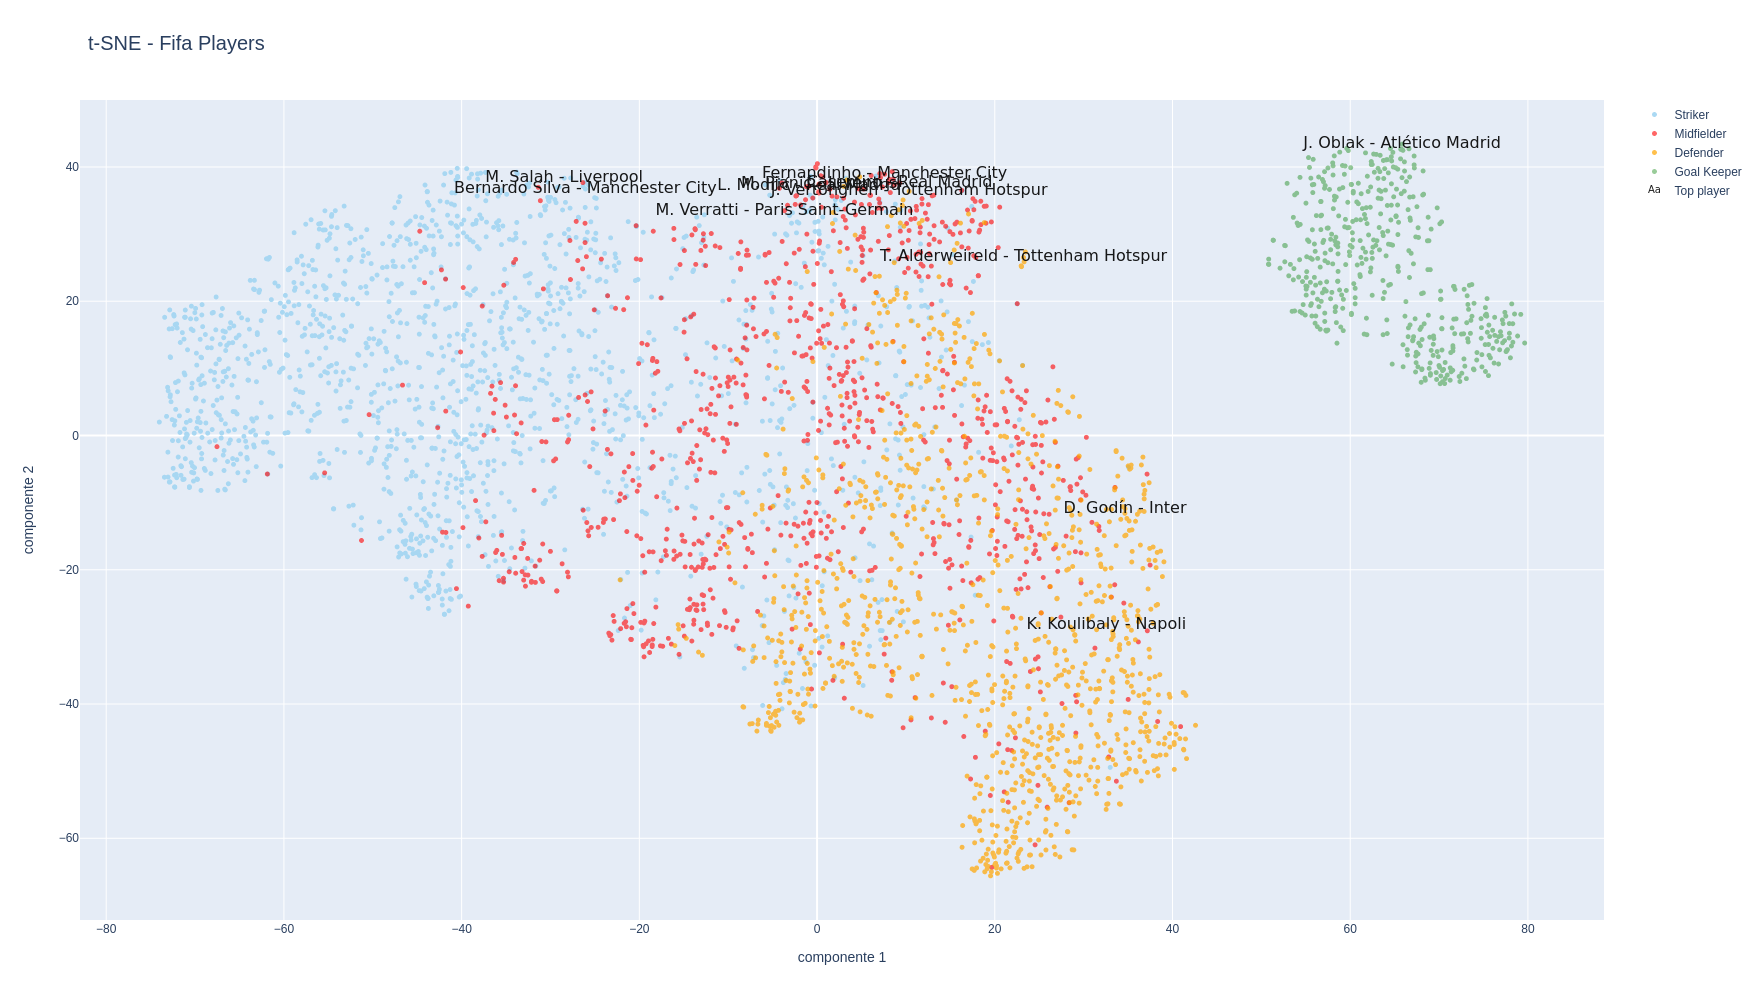

In [12]:
bool_striker = dfo["position"] == 'Forward'
bool_midfielder = dfo["position"] == 'Midfielder'
bool_defender = dfo["position"] == 'Defender'
bool_gk = dfo["position"] == 'GoalKeeper'

bool_crack=dfn["overall"] > 85

palette=['navy','red','#A2D5F2','orange','green','pink']  

striker = go.Scatter(x=X_tsne[bool_striker,0], y=X_tsne[bool_striker,1],
                    name='Striker',
                    text=dfo.loc[bool_striker, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                    opacity=0.9,
                    marker=dict(color=palette[2],size=5),
                    mode='markers')

midfielder = go.Scatter(x=X_tsne[bool_midfielder,0], y=X_tsne[bool_midfielder,1],
                       name='Midfielder',
                       text=dfo.loc[bool_midfielder, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                       opacity=0.6,
                       marker=dict(color=palette[1],size=5),
                       mode='markers')

defender = go.Scatter(x=X_tsne[bool_defender,0], y=X_tsne[bool_defender,1],
                     name='Defender',
                     text=dfo.loc[bool_defender, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                     opacity=0.7,
                     marker=dict(color=palette[3],size=5),
                     mode='markers')

gk = go.Scatter(x=X_tsne[bool_gk,0], y=X_tsne[bool_gk,1],
                name='Goal Keeper',
                text=dfo.loc[bool_gk, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                opacity=0.4,
                marker=dict(color=palette[4],size=5),
                mode='markers')

crack = go.Scatter(x=X_tsne[bool_crack,0], y=X_tsne[bool_crack,1],
                   name='Top player',
                   text=dfo.loc[bool_crack, ['club', 'short_name']].apply(lambda x:f'{x.short_name} - {x.club}', axis=1),
                   textfont=dict(family='sans serif',color='black',size=16),
                   opacity=0.9,
                   mode='text')

data=[striker,midfielder,defender,gk,crack]

layout = go.Layout(title="t-SNE - Fifa Players", 
                   titlefont=dict(size=20),
                   xaxis=dict(title='componente 1'),
                   yaxis=dict(title='componente 2'),
                   autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)
# plot(fig)

## PCA

In [13]:
from sklearn import preprocessing

std_scale=preprocessing.StandardScaler().fit(dfn)
X_scaled=std_scale.transform(dfn) 

In [14]:
from sklearn import decomposition
pca=decomposition.PCA(n_components=4) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(X_scaled) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(X_scaled) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

proporción de varianza por componente:  [0.54971571 0.13679173 0.08387688 0.05219163]
proporción de varianza por componente acumulada:  [0.54971571 0.68650744 0.77038432 0.82257595]
tamaño de los datos:  (4000, 4)


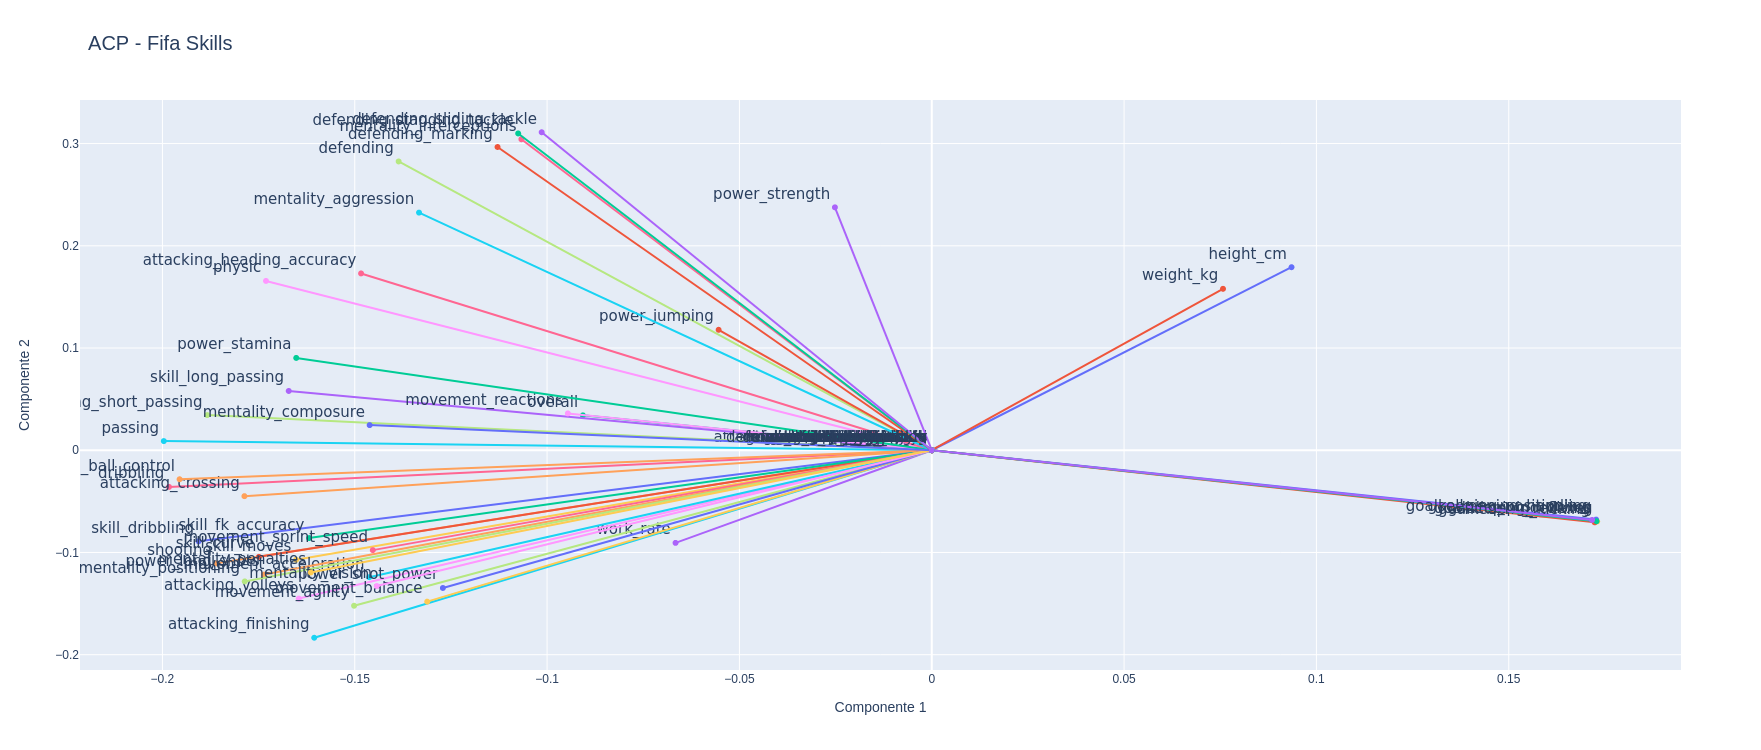

In [15]:
#Graph 1
pcs=pca.components_ 

data=[]

for i, (x,y) in enumerate(zip(pcs[0,:],pcs[1,:])):
    graph=go.Scatter(x=[0,x],y=[0,y],text=dfn.columns[i],
                     mode='lines+markers+text',textposition='top left',textfont=dict(family='sans serif',size=15))
    data.append(graph)

layout = go.Layout(title="ACP - Fifa Skills",titlefont=dict(size=20),
            xaxis=dict(title='Componente 1'),
            yaxis=dict(title='Componente 2'),
            autosize=False, width=1050,height=750,
            showlegend=False)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

In [16]:
MachineGunDataDict={'short_name':'MachineGun'} # club player_positions preferred_foot team_position

MachineGunSkillsDict={'overall':99}
for skills in dfn.columns:
    MachineGunSkillsDict[skills]=99
    
#Lo agregamos a la base:
dfn=dfn.append(MachineGunSkillsDict,ignore_index=True)
dfo=dfo.append(MachineGunDataDict,ignore_index=True)
X_scaled=std_scale.transform(dfn) # volvemos a normalizar con el dato agregado 
#pero con la normalización de la base sin el dato nuevo
X_projected=pca.transform(X_scaled) # volvemos a proyectar pero con el dato nuevo

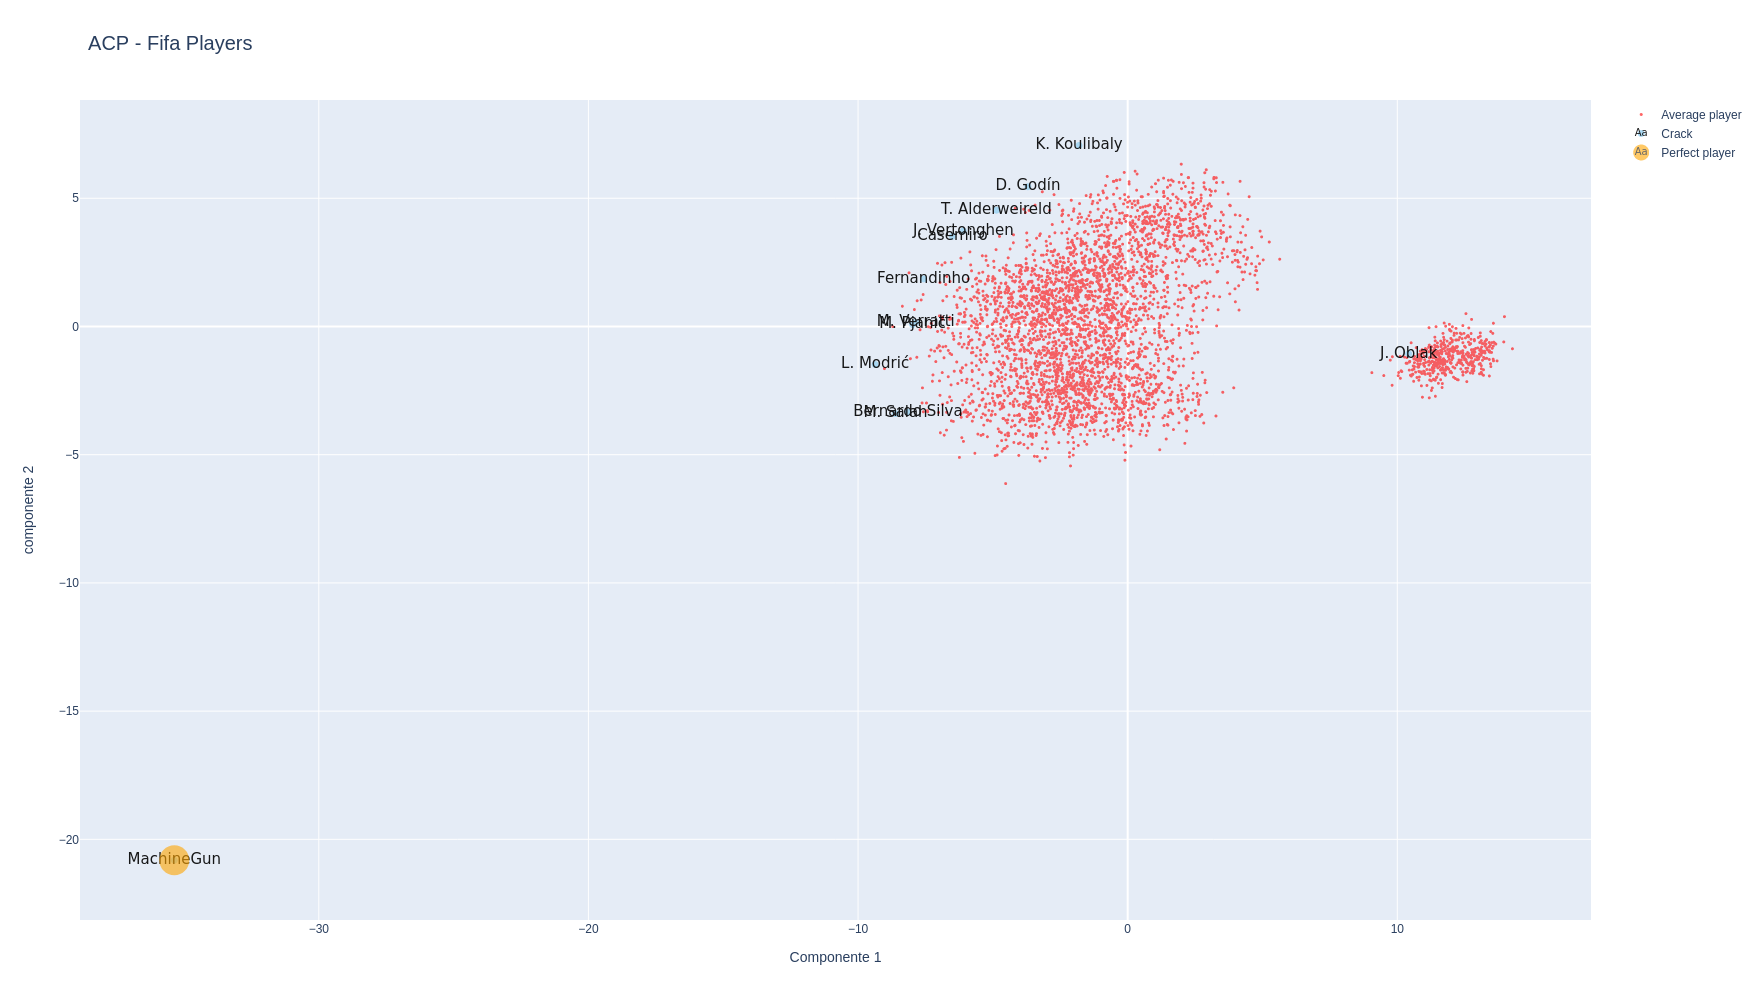

In [22]:
#Graph 2
#Choose your player
recherche_joueur=dfo["short_name"]=='L. Messi'

bool_crack=dfn["overall"] > 85
bool_no_crack=dfn["overall"]<86
bool_machinegun=dfo["short_name"]=='MachineGun'

palette=['navy','red','#A2D5F2','orange','green','pink']  
data=[]

acp_crack =go.Scatter(x=X_projected[bool_crack,0], y=X_projected[bool_crack,1],name='Crack',
                       text=dfo.loc[bool_crack,'short_name'],
                      textfont=dict(family='sans serif',size=15,color='black'),
                      opacity=0.9,marker=dict(color=palette[2],size=7),mode='markers+text')

acp_no_crack =go.Scatter(x=X_projected[bool_no_crack,0], y=X_projected[bool_no_crack,1],name='Average player',
                          text=dfo.loc[bool_no_crack,'short_name'],
                         opacity=0.6,marker=dict(color=palette[1],size=3),mode='markers')

acp_machinegun =go.Scatter(x=X_projected[bool_machinegun,0], y=X_projected[bool_machinegun,1],name='Perfect player',
                           textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=0.6,marker=dict(color=palette[3],size=30),mode='markers+text')


joueur_recherche =go.Scatter(x=X_projected[recherche_joueur,0], y=X_projected[recherche_joueur,1],name='Searched player',
                            text=dfo.loc[recherche_joueur,'short_name'],
                            textfont=dict(family='sans serif',size=20,color='black'),
                           opacity=1,marker=dict(color=palette[4],size=40),mode='markers+text')

data=[acp_no_crack,acp_crack,acp_machinegun,joueur_recherche]

layout = go.Layout(title="ACP - Fifa Players",titlefont=dict(size=20),
                xaxis=dict(title='Componente 1'),
                yaxis=dict(title='componente 2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)

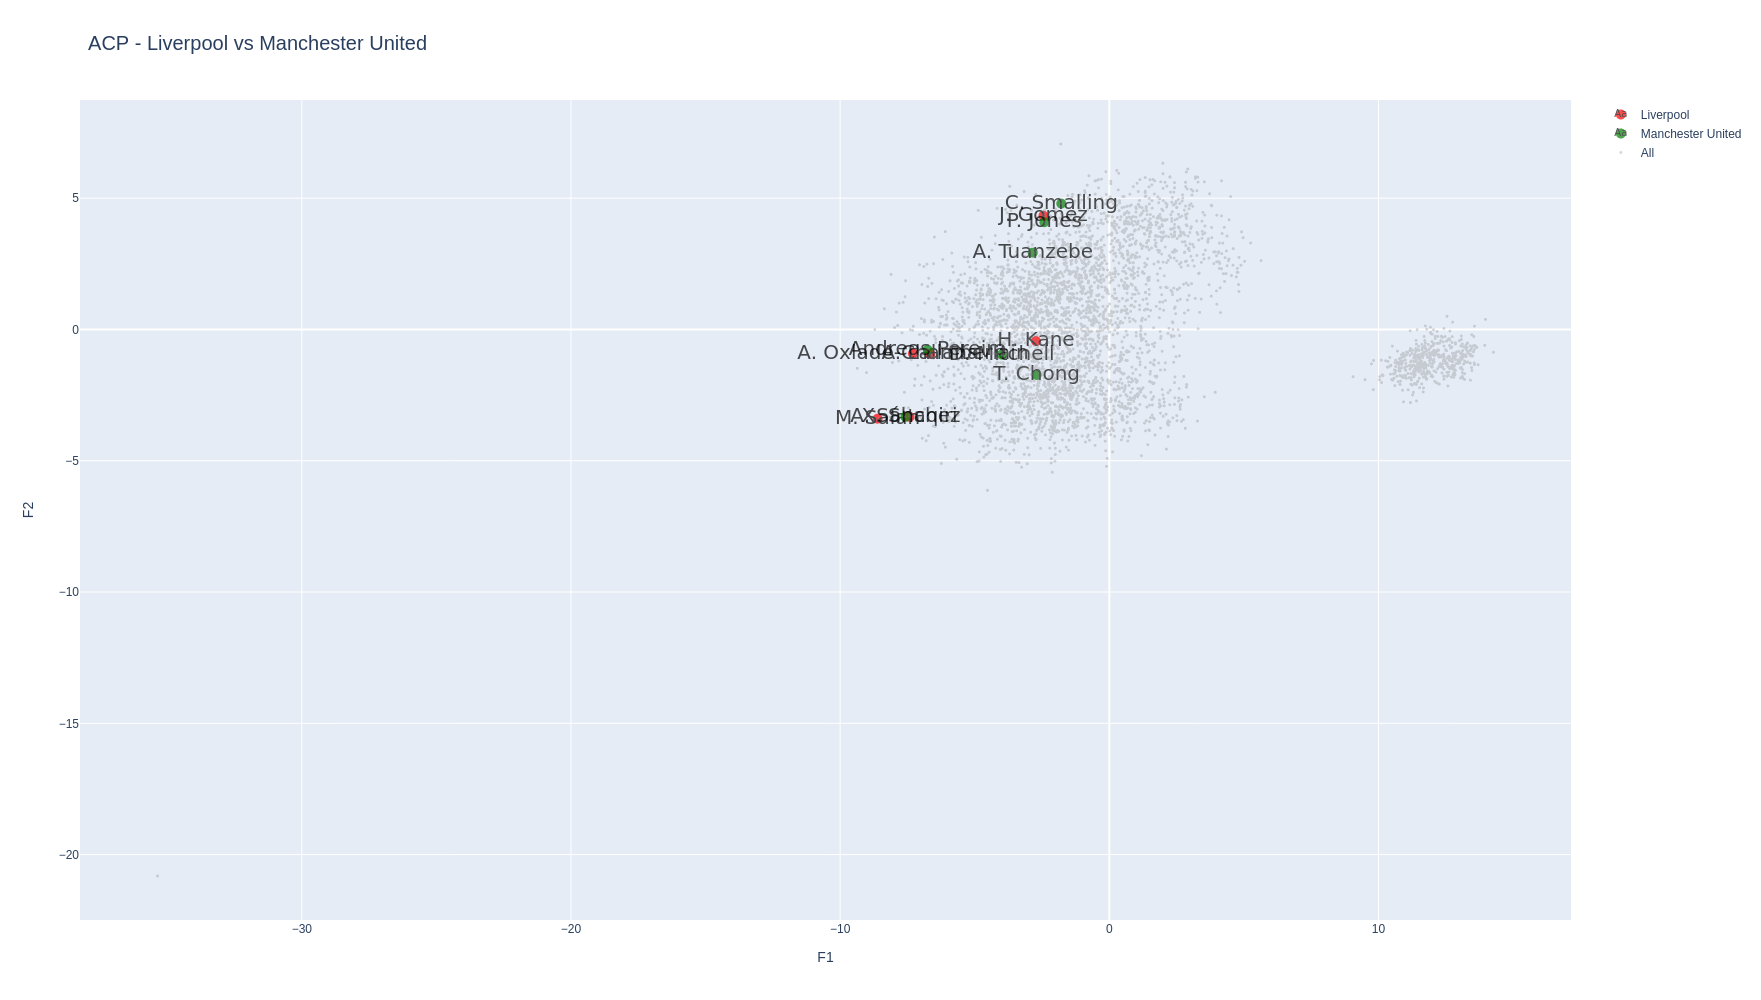

In [24]:
teamA='Liverpool'
teamB='Manchester United'

bool_teamA=dfo["club"]==teamA
bool_teamB=dfo["club"]==teamB

palette=['navy','red','#A2D5F2','orange','green','pink','grey']  
data=[]

acp_teamA =go.Scatter(x=X_projected[bool_teamA,0], y=X_projected[bool_teamA,1],name=teamA,
                      text=dfo.loc[bool_teamA,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[1],size=10),mode='markers+text')

acp_teamB =go.Scatter(x=X_projected[bool_teamB,0], y=X_projected[bool_teamB,1],name=teamB,
                      text=dfo.loc[bool_teamB,'short_name'],
                      textfont=dict(family='sans serif',size=20,color='black'),
                      opacity=0.7,marker=dict(color=palette[4],size=10),mode='markers+text')

acp_all =go.Scatter(x=X_projected[:,0], y=X_projected[:,1],name='All',
                         text=dfo.loc[:,'short_name'],
                         opacity=0.3,marker=dict(color=palette[6],size=3),mode='markers')


data=[acp_teamA,acp_teamB,acp_all]

layout = go.Layout(title="ACP - {} vs {}".format(teamA,teamB),titlefont=dict(size=20),
                xaxis=dict(title='F1'),
                yaxis=dict(title='F2'),
                autosize=False, width=1000,height=1000)

fig = go.Figure(data=data, layout=layout)

iplot(fig)